# 201017 Overlap component clustering reports

In [1]:
using ProgressMeter
using FilePathsBase; using FilePathsBase: /
using GZip
using JSON
using Mmap
using DataFrames
using CSV
using StatsBase
using CategoricalArrays
using HDF5
using Markdown
using DataStructures: counter
using AbstractTrees
using Clustering
using Dates

In [2]:
using PlotlyJS
using Colors
using ColorSchemes

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1865521162928173225\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-17895625373820215540\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1865521162928173225\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [3]:
using Revise

using Midas
using Midas.Pairwise: npairs

using ClusterAnalysis
using ClusterAnalysis: leaf_class_counts, find_strong_clusters, hclust_node_dists, subtree_classes

using MidasPlots
using MidasPlots: Dendrogram, dgleaf_edges, ClassValues
using MidasPlots.Plotly: PlotlyDendrogram, subplot_axes, subplot_axes!, gettraces, setaxes!, vector_attrs!, class_color_strip, make_colorscale

using TriMatrices

## Func defs

In [4]:
findclass(a::CategoricalArray, cls::CategoricalValue) = findall(==(cls), a)
findclass(a::CategoricalArray, i::Integer) = findclass(a, a.pool[i])
findclass(a::CategoricalArray, clss::AbstractVector{<:CategoricalValue}) = findall(∈(clss), a)
findclass(a::CategoricalArray, is::AbstractVector{<:Integer}) = findall(∈(is), a.refs)
selectclass(a::AbstractVector, c::CategoricalArray, cls) = a[findclass(c, cls)]

selectclass (generic function with 1 method)

## File paths

In [5]:
infiles = Dict(
    :taxonomy => p"/home/jared/notebooks/midas/midas-notebooks-2019/build-v1-database/out/3-curated-taxonomy-assignments.csv",
    :distances => p"../../data/intermediate/200727-find-overlaps/genome-pw-distances.raw-float32",
    :overlaps => p"../../data/intermediate/200727-find-overlaps/200729-refseq-curated-1.1_beta-species-overlaps.h5",
);

In [6]:
out_dirs = Dict(
    :intermediate => p"../../data/intermediate/201013-overlap-clustering-analysis/201017-overlap-component-clustering-reports/",
    :reports => p"../../reports/201013-overlap-clustering-analysis/201017-overlap-component-clustering-reports/",
)

for d in values(out_dirs)
    isdir(d) || mkpath(d)
end

## Load data

### Taxonomy

In [7]:
taxdf = DataFrame(CSV.File(infiles[:taxonomy]));

In [8]:
sig_genera = categorical(taxdf[!, :genus])
genera = levels(sig_genera)
ngenera = length(genera)

sig_species = categorical([(row[:genus], row[:species]) for row in eachrow(taxdf)])
species = levels(sig_species)
speciesnames = [join(s, " ") for s in species]
nspecies = length(species)

ngenera, nspecies

(419, 1438)

In [9]:
genus_counts = counts(sig_genera.refs)
species_counts = counts(sig_species.refs)
;

In [10]:
genome_accs = [last(split(k, "/")) for k in taxdf[!, :key]];

In [11]:
species_to_genus = [findfirst(==(genus), genera) for (genus, spname) in species];

In [12]:
nsigs = size(taxdf, 1)

50752

### Distances

In [13]:
pw_data = Mmap.mmap(open(infiles[:distances], "r"), Vector{Float32}, (npairs(nsigs),));

pw_dists = TriMatrix(TriSymmetric{false}(), nsigs, pw_data);

In [14]:
@assert !any(<(0), pw_data)

### Overlaps

In [15]:
h5open(string(infiles[:overlaps])) do h5
    @assert read(h5, "genome_keys") == taxdf[!, :key]

    global min_inter = collect(zip(read(h5, "min_inter_indices"), read(h5, "min_inter_dists")))
    global max_intra = collect(zip(read(h5, "max_intra_indices"), read(h5, "max_intra_dists")))

    global has_overlap = read(h5, "has_overlap")
    global overlap_components_vec = read(h5, "overlap_components")
end;

In [16]:
overlap_components = [findall(==(i), overlap_components_vec) for i in 1:maximum(overlap_components_vec)];

## Plot and reporting funcs

In [17]:
pal = collect(colorschemes[:tableau_20].colors)
pal = pal[vcat(1:2:17, 2:2:18)]
classcolors = ClassValues(pal, Gray(.75))

In [18]:
struct Namespace
    _fields::Dict{Symbol, Any}
end
    
Namespace(; kw...) = Namespace(Dict(kw))

function Base.getproperty(ns::Namespace, p::Symbol)
    f = getfield(ns, :_fields)
    p == :_fields && return f
    try
        return f[p]
    catch KeyError
        error("Namespace has no field $p")
    end
end

function Base.setproperty!(ns::Namespace, p::Symbol, v)
    f = getfield(ns, :_fields)
    f[p] = v
end

macro unpack_ns(e, symbols::Symbol...)
    x = [Expr(:., :ns, QuoteNode(s)) for s in symbols]
    rhs = quote
        let ns = $(esc(e))
            $(Expr(:tuple, x...))
        end
    end
    return Expr(:(=), Expr(:tuple, esc.(symbols)...), rhs)
end

@unpack_ns (macro with 1 method)

In [19]:
function componentdata(i::Int)
    i = i
    comp = overlap_components[i]
    nspecies = length(comp)
    idxs = [findclass(sig_species, c) for c in comp]
    idxs_flat = vcat(idxs...)
    genera = unique(g for (g, s) in species[comp])
    singlegenus = length(genera) == 1
    
    if singlegenus
        genus = only(genera)
        groupnames = [s for (g, s) in species[comp]]
    else
       genus = nothing
       groupnames = speciesnames[comp]
    end
    
    classnames = ClassValues(groupnames, "(mixed)");
    ngenomes = length(idxs_flat)
    genome_labels = [l for (l, n) in enumerate(species_counts[comp]) for _ in 1:n];
    dmat = pw_dists[idxs_flat, idxs_flat];
    
    return Namespace(;
        i, species=comp, idxs, idxs_flat, genera, singlegenus,
        genus, groupnames, classnames, ngenomes, nspecies,
        genome_labels, dmat
    )
end

componentdata (generic function with 1 method)

In [ ]:
function do_clustering(comp)
    # Cluster
    hc = hclust(comp.dmat, linkage=:complete)
    tree = HClustTree(hc)

    # Find optimal cut
    strong_clusters = find_strong_clusters(tree, comp.dmat);
    node_classes = subtree_classes(tree, comp.genome_labels, with_leaves=true);
    cut = makecut(node -> node.id ∈ strong_clusters && node_classes[node.id] != 0, tree);
    
    # Coarsen cut if needed
    truncated_from = nothing
    max_leaves = 40
    
    if length(cut) > max_leaves
        truncated_from = length(cut)
        cut = coarsen_cut(tree, cut, k=max_leaves, accept=node -> node_classes[node.id] != 0);
    end
    
    dg = Dendrogram(tree, trunc=node -> node.id ∈ cut)
    leaf_classes = [node_classes[id] for id in dg.leaves]
    classnames = ClassValues(comp.groupnames, "(mixed)")
    
    return Namespace(;
        tree, dg, cut, strong_clusters, node_classes, truncated_from, leaf_classes,
        classnames,
    )
end

In [ ]:
function component_species_df(comp)
    DataFrame([(genus=species[i][1], species=species[i][2], ngenomes=species_counts[i]) for i in comp.species])
end

function component_edges_df(comp)
    df = DataFrame([String, String, Int, Float64], [:A, :B, :C, :D])
    
    for ((i, j), c) in overlap_edges
        if i ∈ comp.species
            push!(df, (
                speciesnames[i],
                speciesnames[j],
                c,
                c / (species_counts[i] * species_counts[j])
            ))
        end
    end
    
    sort!(df, [:A, :B])
    rename!(df, ["Intra Species", "Inter Species", "Overlapping Pairs", "Overlap fraction"])
    
    return df
end

In [ ]:
function plotly_dendrogram(clust, dgattr=attr(); horizontal::Bool=false)
    @unpack_ns clust dg tree node_classes strong_clusters classnames
    
    pdg = PlotlyDendrogram(dg, dgattr, horizontal=horizontal)
    
    # Node trace attributes
    vector_attrs!(pdg.nodes_trace, pdg.node_ids) do id
        node = tree.nodes[id]
        c = node_classes[id]
        return Dict(
            :marker_size => id ∈ strong_clusters ? 8 : 4,
            :marker_color => classcolors[c],
            :text => string(id),
            :customdata => [
                node.count,
                classnames[c],
                string(id ∈ strong_clusters ? "Strong" : "Weak", " cluster"),
            ],
        )
    end
    
    yax = horizontal ? "x" : "y"
    merge!(pdg.nodes_trace, attr(
        hovertemplate="""
        <b>%{text}</b><br>
        %{$yax:.3f}<br>
        %{customdata[0]} genomes<br>
        %{customdata[1]}<br>
        %{customdata[2]}
        <extra></extra>
        """,
    ))
    
    # Branch trace colors
    for (id, trace) in pdg.branch_traces
        trace[:line_color] = classcolors[node_classes[id]]
    end
    
    return pdg
end

In [ ]:
function leaf_color_strip(clust; vertical::Bool=false, kw...)
    @unpack_ns clust dg tree leaf_classes classnames
    
    edges = dgleaf_edges(dg)
    
    return class_color_strip(
        leaf_classes,
        classcolors;
        vertical=vertical,
        edges=edges,
        text=[id <= tree.n ? "Genome $id" : "Cluster $id" for id in dg.leaves],
        customdata=[[classnames[c]] for c in leaf_classes],
        hovertemplate="""
        <b>%{text}</b><br>
        %{customdata[0]}
        <extra></extra>
        """,
        gap=1,
        kw...
    )
end

In [ ]:
function big_dendrogram(clust)
    # Y axes
    yaxes = subplot_axes!(
        [
            attr(visible=false),
            attr(rangemode=:nonnegative),
        ],
        [.1, 1.0],
        sep=0.02
    )
    
    # Dendrogram
    pdg = plotly_dendrogram(clust, attr(yaxis="y2"))
    
    # Labels
    labels_t = leaf_color_strip(clust)
    
    layout = Layout(
        xaxis=attr(
            visible=false,
        ),
        showlegend=false,
        hovermode=:closest,
    )
    setaxes!(layout, :y, yaxes)
    
    return plot(vcat(gettraces(pdg), [labels_t]), layout)
end

In [ ]:
function clustermap(comp, clust)
    @unpack_ns clust tree dg leaf_classes classnames
    
    # X axes
    xaxes = subplot_axes!(
        [
            attr(
                rangemode=:nonnegative,
                autorange=:reversed,
            ),
            attr(
                visible=false,
            ),
            attr(
                visible=false,
                scaleanchor=:y,
            ),
        ],
        [.4, .05, 1.],
        sep=.01,
    )
    
    # Dendrogram
    pdg = plotly_dendrogram(clust, horizontal=true)
    
    # Labels
    labels_t = leaf_color_strip(clust, xaxis="x2", vertical=true)
    
    # Heatmap
    edges = dgleaf_edges(dg)
    leaf_names = [id <= tree.n ? "Genome $id" : "Cluster $id" for id in dg.leaves]
    hm_leaf_text = [string(n, ": ", classnames[c]) for (n, c) in zip(leaf_names, leaf_classes)]
    
    hm_t = heatmap(
        z=hclust_node_dists(tree, comp.dmat, dg.leaves),
        x=edges,
        y=edges,
        customdata=[[t1, t2] for t1 in hm_leaf_text, t2 in hm_leaf_text],
        hovertemplate="""
        %{customdata[0]}<br>
        %{customdata[1]}<br>
        %{z:.3f}
        <extra></extra>
        """,
        colorscale=make_colorscale(:magma),
        xaxis="x3",
    )
    
    layout = Layout(
        yaxis=attr(
            visible=false,
        ),
        showlegend=false,
        hovermode=:closest,
        width=1000,
        height=800,
    )
    setaxes!(layout, :x, xaxes)
    
    return plot(vcat(gettraces(pdg), [hm_t, labels_t]), layout)
end

# ?

In [22]:
comp = componentdata(3)
speciesnames[comp.species]

3-element Array{String,1}:
 "Corynebacterium jeikeium"
 "Corynebacterium urealyticum"
 "Corynebacterium xerosis"

In [27]:
Base.propertynames(ns::Namespace) = collect(keys(ns._fields))

In [28]:
species_counts[comp.species]

3-element Array{Int64,1}:
 19
  2
  2

In [32]:
d = let
    idxs = comp.idxs[1]
    pw_dists[idxs, idxs]
end

19×19 Array{Float32,2}:
 0.0       0.4546    0.874775  0.702885  …  0.987272  0.733977  0.990717
 0.4546    0.0       0.88383   0.735503     0.988205  0.748664  0.991176
 0.874775  0.88383   0.0       0.872905     0.989829  0.874631  0.992779
 0.702885  0.735503  0.872905  0.0          0.986147  0.654589  0.988645
 0.87209   0.879641  0.36697   0.873794     0.992167  0.874491  0.9934
 0.869413  0.877073  0.39245   0.869525  …  0.989538  0.868529  0.991414
 0.871266  0.880215  0.364455  0.869176     0.989888  0.870993  0.992606
 0.868792  0.871983  0.367333  0.870652     0.988046  0.870573  0.990919
 0.87333   0.881298  0.366863  0.872271     0.992939  0.872228  0.994414
 0.864376  0.876098  0.384172  0.863707     0.992553  0.86347   0.993906
 0.85609   0.869248  0.417134  0.863798  …  0.989333  0.869825  0.991205
 0.868551  0.878563  0.438181  0.86365      0.992148  0.866066  0.993582
 0.73204   0.745507  0.87277   0.630581     0.986875  0.374215  0.988885
 0.473976  0.464425  0.874037

In [37]:
tree = HClustTree(hclust(d, linkage=:complete))
dg = Dendrogram(tree)

Dendrogram with 37 nodes and 19 leaves

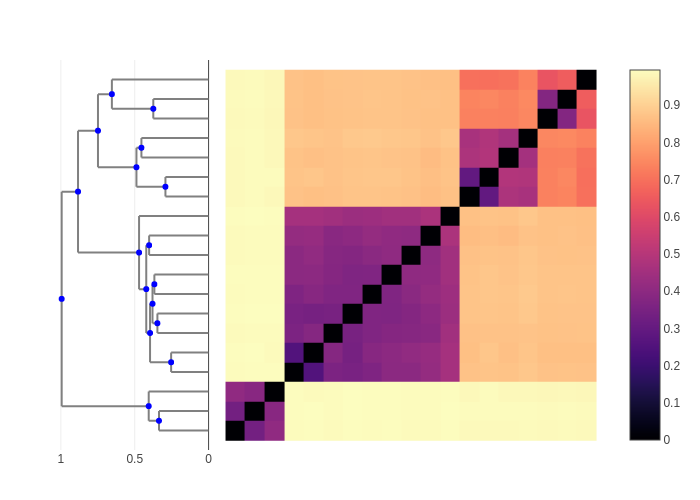

In [47]:
let
    # X axes
    xaxes = subplot_axes!(
        [
            attr(
                rangemode=:nonnegative,
                autorange=:reversed,
            ),
            attr(
                visible=false,
                scaleanchor=:y,
            ),
        ],
        [.4, 1.],
        sep=.01,
    )
    
    # Dendrogram
    pdg = PlotlyDendrogram(dg, horizontal=true, branch_attr=attr(line_color=:gray))
    
    vector_attrs!(pdg.nodes_trace, pdg.node_ids) do id
        node = tree.nodes[id]
        return Dict(
            :text => string(id),
            :customdata => [
                node.count,
            ],
        )
    end
    
    merge!(pdg.nodes_trace, attr(
        hovertemplate="""
        <b>%{text}</b><br>
        %{x:.3f}<br>
        %{customdata[0]} genomes
        <extra></extra>
        """,
        marker_color=:blue,
            
    ))
    
    # Heatmap
    edges = dgleaf_edges(dg)
    leaf_names = [id <= tree.n ? "Genome $id" : "Cluster $id" for id in dg.leaves]
    
    hm_t = heatmap(
        z=hclust_node_dists(tree, d, dg.leaves),
        x=edges,
        y=edges,
        customdata=[[t1, t2] for t1 in leaf_names, t2 in leaf_names],
        hovertemplate="""
        %{customdata[0]}<br>
        %{customdata[1]}<br>
        %{z:.3f}
        <extra></extra>
        """,
        colorscale=make_colorscale(:magma),
        xaxis="x2",
    )
    
    layout = Layout(
        yaxis=attr(
            visible=false,
        ),
        showlegend=false,
        hovermode=:closest,
        width=1000,
        height=800,
    )
    setaxes!(layout, :x, xaxes)
    
    return plot(vcat(gettraces(pdg), [hm_t]), layout)
end

In [52]:
magma = make_colorscale(:magma);

In [57]:
d2 = d[dg.leaves, :]
sort!(d2, dims=2)

19×19 Array{Float32,2}:
 0.0  0.335622  0.405212  0.986147  0.986875  …  0.992167  0.992553  0.992939
 0.0  0.335622  0.3852    0.988645  0.988885     0.993582  0.993906  0.994414
 0.0  0.3852    0.405212  0.982331  0.983355     0.992749  0.993202  0.993871
 0.0  0.253508  0.350329  0.359032  0.364455     0.989888  0.992319  0.992606
 0.0  0.253508  0.342099  0.380931  0.384172     0.988512  0.992553  0.993906
 0.0  0.346449  0.359032  0.367333  0.379542  …  0.988046  0.990332  0.990919
 0.0  0.342099  0.346449  0.350329  0.364754     0.992939  0.993871  0.994414
 0.0  0.364455  0.366863  0.36697   0.367333     0.989829  0.992381  0.992779
 0.0  0.364754  0.36697   0.379542  0.39436      0.992167  0.993202  0.9934
 0.0  0.37885   0.382161  0.39245   0.395172     0.989538  0.990929  0.991414
 0.0  0.389819  0.398839  0.402418  0.405074  …  0.989333  0.990402  0.991205
 0.0  0.434035  0.438181  0.446804  0.447363     0.992148  0.992749  0.993582
 0.0  0.292087  0.464425  0.473976  0.6974

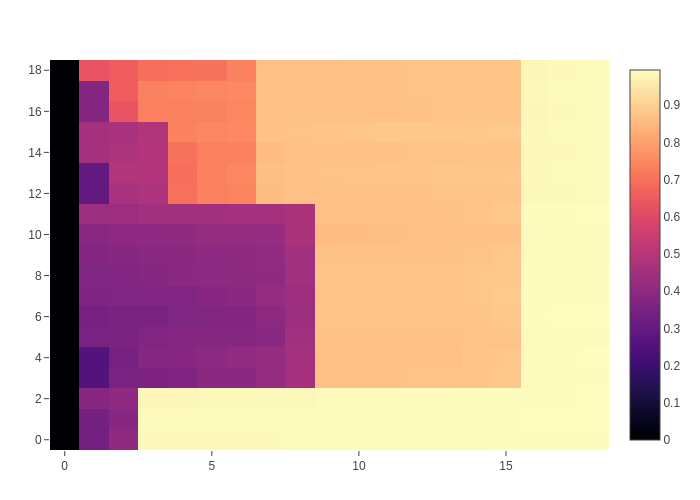

In [60]:
plot([heatmap(z=d2, transpose=true, colorscale=magma)])